In [1]:
#!pip install nltk

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from collections import Counter

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [3]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin', names=['label', 'id', 'date', 'query', 'name', 'text'])
df = df.drop(columns=['id', 'date', 'query', 'name'])
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Data distribution')

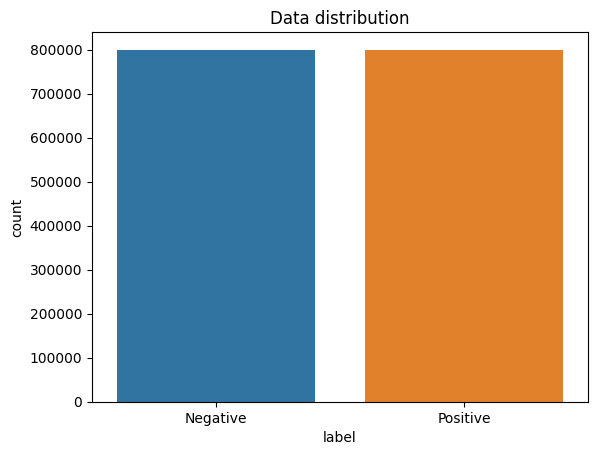

In [4]:
value_counts = df['label'].value_counts().reset_index()
value_counts = value_counts.replace({0:'Negative', 4:'Positive'})

sns.barplot(data=value_counts, x='label', y='count').set_title('Data distribution')

In [5]:
re_word = r'@\S+|https?://\S+|[^A-Za-z0-9]+'
stemmer = SnowballStemmer(language='english')

def tokenizer(text, stem=False):
    text = re.sub(re_word, ' ', str(text).lower()).strip()
    tokens = []
    for word in text.split():
        if word not in stopwords.words('english'):
            tokens.append(stemmer.stem(word) if stem else word)
    return tokens

df['tokens'] = df['text'].apply(lambda x : tokenizer(x))

In [6]:
counter = Counter(token for tokens in df['text'] for token in tokens.split())
vocab_tokens = ['<pad>', '<unk>'] + sorted(counter)
vocab = {token: id for id, token in enumerate(vocab_tokens)}

def get_id(token):
    return vocab.get(token, vocab['<unk>'])

In [7]:
max_len = 100

def pad(tokens):
    id = [get_id(token) for token in tokens]
    if len(id) < max_len:
        id += [vocab['<pad>']] * (max_len - len(id))
    else:
        id = id[:max_len]
    return id
df['input_id'] = df['tokens'].apply(pad)

In [8]:
df['label'] = df['label'].map({0:0, 4:1})
df.label.values

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
df.head()

,label,text,tokens,input_id
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, bummer, shoulda, got, david, carr, thir...","[775317, 808408, 1210141, 928412, 852845, 8165..."
1,0,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,...","[1295093, 1294447, 894112, 1255372, 1091738, 8..."
2,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, times, ball, managed, save, 50, ...","[866091, 1081280, 1265709, 780480, 1080326, 11..."
3,0,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]","[1316826, 797336, 899355, 1039226, 1065384, 90..."
4,0,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]","[787580, 1077412, 1201333, 0, 0, 0, 0, 0, 0, 0..."


In [10]:
input_id = df['input_id'].to_list()
label = df['label'].to_list()

x_train, x_tmp, y_train, y_tmp = train_test_split(input_id, label, test_size=0.2, random_state=42)
x_dev, x_test, y_dev, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
dev_dataset = TensorDataset(torch.tensor(x_dev, dtype=torch.long), torch.tensor(y_dev, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)


In [11]:
class LSTM_model(nn.Module):
    def __init__(self, vocab_size=len(vocab), embed_dim=300, hidden_dim=32, output_dim=1, pad_idx=0):
        super(LSTM_model, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 

    def forward(self, x):                               
        embedded = self.embedding(x)                    
        lstm_out, (hidden, _) = self.lstm(embedded)     
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        return output.squeeze(1)  

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM_model().to(device)
print(device)

cuda


In [13]:
epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.07)

In [14]:
train_losses = []
dev_losses = []
train_accuracies = []
dev_accuracies = []

best_accuracy = 0.0
patience = 5
epochs_no_improve = 0
best_model_path = "best_model.pt"

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    n_correct_train = 0
    n_samples_train = 0

    for input_ids, labels in train_loader:
        input_ids = input_ids.to(device)
        labels = labels.float().to(device) 

        outputs = model(input_ids).squeeze()  
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).long()  
        n_correct_train += (predicted == labels.long()).sum().item()
        n_samples_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * n_correct_train / n_samples_train

    model.eval()
    dev_loss = 0.0
    n_correct = 0
    n_samples = 0

    with torch.no_grad():
        for input_ids, labels in dev_loader:
            input_ids = input_ids.to(device)
            labels = labels.float().to(device)

            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            dev_loss += loss.item()

            predicted = (outputs > 0.5).long()
            n_correct += (predicted == labels.long()).sum().item()
            n_samples += labels.size(0)

    dev_loss = dev_loss / len(dev_loader)
    dev_acc = 100.0 * n_correct / n_samples

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"  Train Loss     : {train_loss:.4f}")
    print(f"  Train Accuracy : {train_acc:.2f}%")
    print(f"  Dev Loss       : {dev_loss:.4f}")
    print(f"  Dev Accuracy   : {dev_acc:.2f}%")

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    train_accuracies.append(train_acc)
    dev_accuracies.append(dev_acc)

    if dev_acc > best_accuracy:
        best_accuracy = dev_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping")
        break

print("Training done")

Epoch [1/20]
  Train Loss     : 0.4891
  Train Accuracy : 74.74%
  Dev Loss       : 0.4554
  Dev Accuracy   : 77.72%
Epoch [2/20]
  Train Loss     : 0.4429
  Train Accuracy : 78.18%
  Dev Loss       : 0.4461
  Dev Accuracy   : 78.12%
Epoch [3/20]
  Train Loss     : 0.4171
  Train Accuracy : 79.83%
  Dev Loss       : 0.4517
  Dev Accuracy   : 78.31%
Epoch [4/20]
  Train Loss     : 0.3875
  Train Accuracy : 81.65%
  Dev Loss       : 0.4565
  Dev Accuracy   : 76.72%
Epoch [5/20]
  Train Loss     : 0.3521
  Train Accuracy : 83.71%
  Dev Loss       : 0.4708
  Dev Accuracy   : 77.41%
Epoch [6/20]
  Train Loss     : 0.3167
  Train Accuracy : 85.63%
  Dev Loss       : 0.5335
  Dev Accuracy   : 77.23%
Epoch [7/20]
  Train Loss     : 0.2881
  Train Accuracy : 87.05%
  Dev Loss       : 0.5565
  Dev Accuracy   : 77.42%
Epoch [8/20]
  Train Loss     : 0.2694
  Train Accuracy : 87.97%
  Dev Loss       : 0.5430
  Dev Accuracy   : 76.59%
Early stopping
Training done


In [15]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_loss = 0.0
n_correct_test = 0
n_samples_test = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for input_ids, labels in test_loader:
        input_ids = input_ids.to(device)
        labels = labels.float().to(device)

        outputs = model(input_ids).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).long()
        n_correct_test += (predicted == labels.long()).sum().item()
        n_samples_test += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = 100.0 * n_correct_test / n_samples_test

print("Test Evaluation")
print(f"  Test Loss     : {test_loss:.4f}")
print(f"  Test Accuracy : {test_acc:.2f}%")

print(classification_report(all_labels, all_preds))


Test Evaluation
  Test Loss     : 0.4518
  Test Accuracy : 78.43%
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.80     79807
         1.0       0.82      0.72      0.77     80193

    accuracy                           0.78    160000
   macro avg       0.79      0.78      0.78    160000
weighted avg       0.79      0.78      0.78    160000



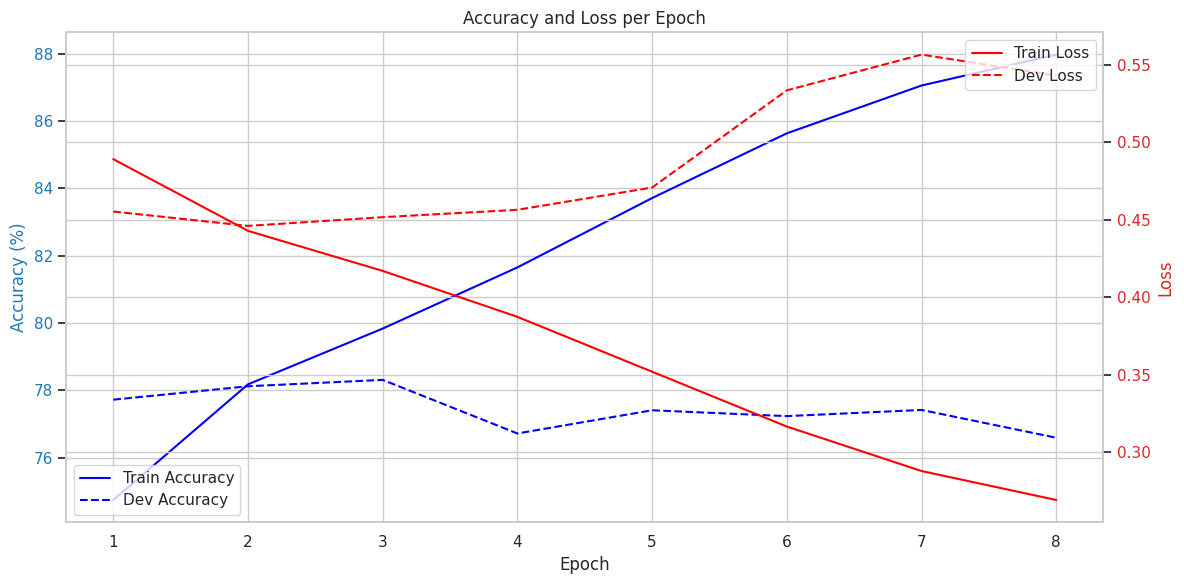

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs_range = list(range(1, len(train_losses) + 1))

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)", color="tab:blue")
ax1.plot(epochs_range, train_accuracies, label="Train Accuracy", color="blue")
ax1.plot(epochs_range, dev_accuracies, label="Dev Accuracy", color="blue", linestyle='--')
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.set_ylabel("Loss", color="tab:red")
ax2.plot(epochs_range, train_losses, label="Train Loss", color="red")
ax2.plot(epochs_range, dev_losses, label="Dev Loss", color="red", linestyle='--')
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.legend(loc="upper right")

plt.title("Accuracy and Loss per Epoch")
plt.tight_layout()
plt.show()